In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:

# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 2. Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])


In [4]:

# 3. Download dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]


In [8]:
# PATH =  '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/FifthSession/'
# pickle.dump(test_dataset , open(PATH +"test_dataset.pkl","wb"))

In [9]:
images, labels = full_train_dataset.data , full_train_dataset.targets

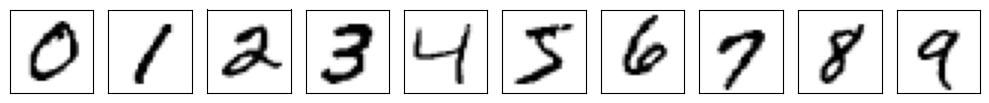

In [10]:
#lets visualize:
fig, ax = plt.subplots(nrows =1, ncols=10,sharex = True, sharey = True, figsize = (10, 2))
for i in range(10):
  img = images[labels == i][0]
  ax[i].imshow(img,cmap =  'Greys')
  #plt.title(f"Label: {i}")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

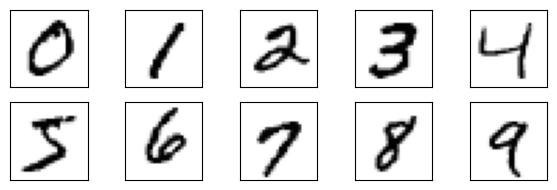

In [11]:
#lets visualize:
fig, ax = plt.subplots(nrows =2, ncols=5,sharex = True, sharey = True , figsize = (6,2))
ax = ax.flatten()
for i in range(10):
  img = images[labels == i][0]
  ax[i].imshow(img,cmap =  'Greys')
  #plt.title(f"Label: {i}")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

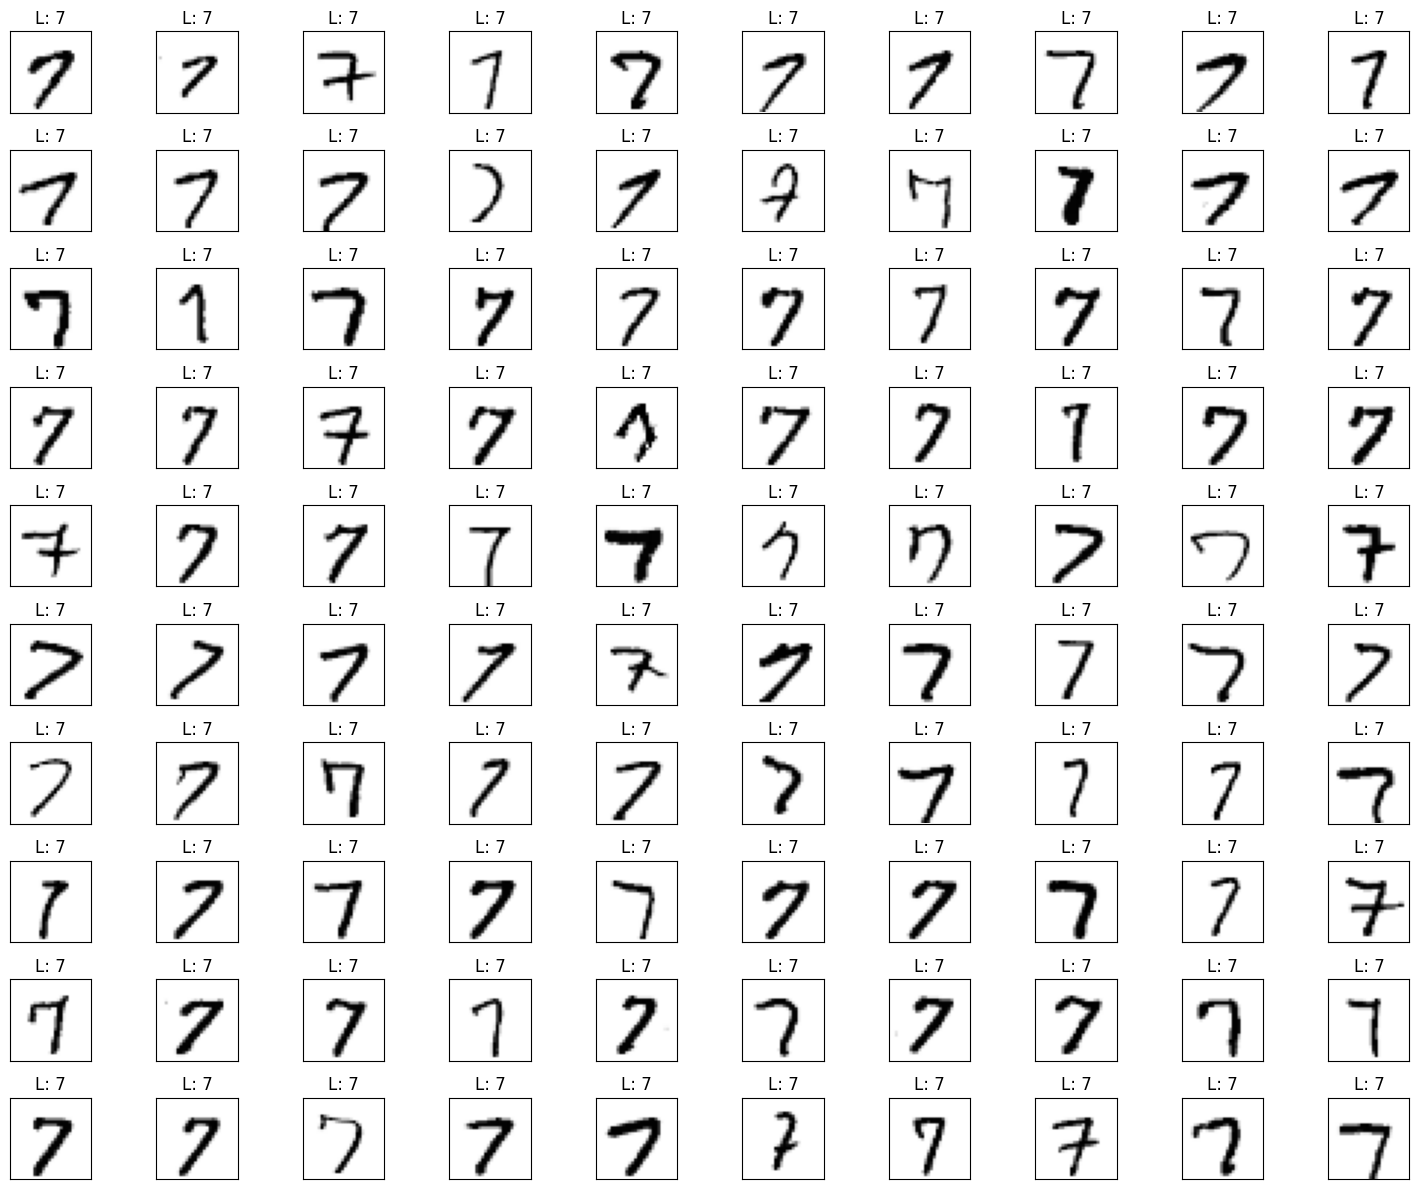

In [12]:
fig , ax = plt.subplots(nrows = 10, ncols = 10,sharex = True , sharey = True, figsize= (15, 12))
ax = ax.flatten()
number = 7
images_ = images[labels == number]
for i in range(100):
  img = images_[i]
  ax[i].imshow(img, cmap = 'Greys')
  ax[i].set_title(f"L: {number}")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [13]:
# What is the Channel Dimension?
# In PyTorch, images are represented as tensors with shape:

# (C,
#
# H,
#
# W)
# (C, H, W)
# Where:

# C = number of channels (e.g., 1 for grayscale, 3 for RGB)

# H = height (number of pixels vertically)

# W = width (number of pixels horizontally)

In [14]:
# 4. Split into train and validation sets (80/20 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [15]:
# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [49]:
# 6. Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.layers(x)
        predicted = self.output(logits)
        return logits , predicted


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pickle
from collections import defaultdict

In [51]:
# ##saving for first run time:
PATH =  '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/FifthSession/'
estimator = SimpleNN() #before training
history = defaultdict(list)
finished_epochs = 0
pickle.dump(finished_epochs, open(PATH + 'finished_epochs.pkl', 'wb'))#save object
#save weights
torch.save(estimator.state_dict(), PATH + 'model_weights.pth')#weights random
pickle.dump(history,open(PATH+'history.pkl','wb') )

In [52]:
#we use this cell for any interruption of connection when rerun the model:
PATH =  '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/FifthSession/'
estimator = SimpleNN().to(device)#parameters intialized with random numbers
estimator.load_state_dict(torch.load(PATH + 'model_weights.pth'))#pre trained weights
#load fininshed_epochs:
finished_epochs = pickle.load(open(PATH + 'finished_epochs.pkl', 'rb'))
history = pickle.load(open(PATH + 'history.pkl', 'rb'))#save object

In [53]:
# 7. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(estimator.parameters(), lr=0.001)

In [54]:
finished_epochs

0

In [55]:
epochs = 1000 - finished_epochs
current_epoch = finished_epochs

In [56]:
#when we need to save the model weights for learning for many times not one time
patience = 10
counter = 0
best_val_loss = float('inf')
for epoch in range(epochs):
  loss_per_epoch = 0
  Acc_train = 0
  Acc_val = 0
  for feature , labels in train_loader:
    #to GPU
    feature, labels = feature.to(device), labels.to(device)
    # forward
    logits, y_pred = estimator(feature)
    # calculate loss fn
    loss = criterion(logits, labels)
    loss_per_epoch += loss.item()
    Acc_train += (y_pred.argmax(dim =1) == labels).sum().item() / len(labels)

    # reset gradients
    optimizer.zero_grad()
    # calculate gradients
    loss.backward()
    # update weights
    optimizer.step()

  #UserWarning: Using a target size (labels)(torch.Size([64])) that is different to the input size (y_predict)(torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # warning that make results wrong
  loss_per_epoch /= len(train_loader)
  Acc_train /= len(train_loader)
  loss_per_epoch /= len(train_loader)
  history['train_loss'].append(loss_per_epoch)
  history['train_acc'].append(Acc_train)
  # validation Check
  with torch.no_grad():
    validation_loss = 0
    for x_valid , y_valid in val_loader:
      x_valid, y_valid = x_valid.to(device), y_valid.to(device)
      logits, y_val_pred = estimator(x_valid)
      loss = criterion(logits, y_valid)
      validation_loss += loss.item()
      Acc_val += (y_val_pred.argmax(dim = 1) == y_valid).sum().item() / len(y_valid)
    validation_loss /= len(val_loader)
    Acc_val /= len(val_loader)
    if round(validation_loss, 5) < best_val_loss:#this true when validation loss is always decreases
      best_val_loss = validation_loss
      counter = 0
    else: #this will happen when validation loss increases or remain the same
      counter += 1
      if counter >= patience:
        print("Early Stopping")
        #save weights
        torch.save(estimator.state_dict(), PATH + 'model_weights.pth')
        pickle.dump(history,open(PATH+'history.pkl','wb') )
        break
    history['val_loss'].append(validation_loss)
    history['val_acc'].append(Acc_val)
    current_epoch += 1
    if epoch %10 ==0:
      #save weights
      finished_epochs = current_epoch
      #we need to save finished_epochs:
      pickle.dump(finished_epochs, open(PATH + 'finished_epochs.pkl', 'wb'))#save object
      pickle.dump(history,open(PATH+'history.pkl','wb') )#save history
      torch.save(estimator.state_dict(), PATH + 'model_weights.pth')
      print(f"epoch:{current_epoch}, loss_Train: {loss_per_epoch:0.3f} ,Acc_train: {Acc_train * 100:0.3f}, loss_Validation: {validation_loss}, Acc_valid:{Acc_val * 100:0.3f}")

epoch:1, loss_Train: 0.000 ,Acc_train: 91.636, loss_Validation: 0.15920003776352668, Acc_valid:95.263
epoch:11, loss_Train: 0.000 ,Acc_train: 99.413, loss_Validation: 0.10705214489951312, Acc_valid:97.501
Early Stopping


In [31]:
features.shape

NameError: name 'features' is not defined

In [32]:
import matplotlib.pyplot as plt

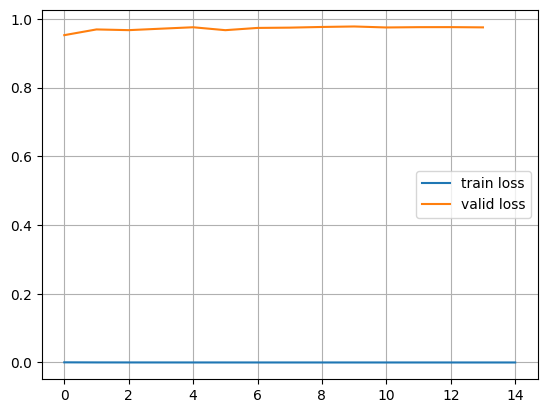

In [57]:
#draw learing Curves:#losses
plt.plot(history['train_loss'], label = 'train loss')
plt.plot(history['val_acc'], label = 'valid loss')
plt.legend()
plt.grid(True)
plt.show()

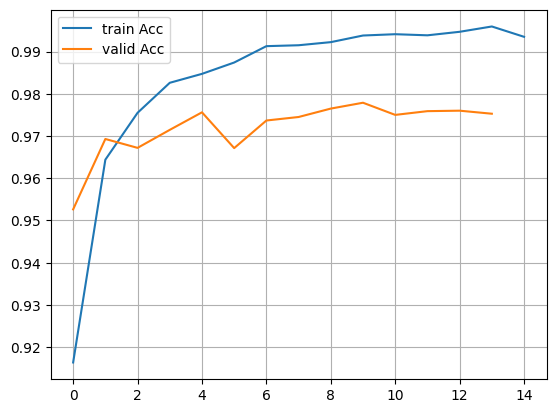

In [58]:
#Acc
plt.plot(history['train_acc'], label = 'train Acc')
plt.plot(history['val_acc'], label = 'valid Acc')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
history

defaultdict(list,
            {'train_loss': [7.464617829948961e-05,
              4.530065107139296e-05,
              3.624156174400112e-05,
              2.948059998383502e-05,
              2.61034243239197e-05,
              2.6674186911007545e-05,
              2.42396480254862e-05,
              1.71561421198268e-05,
              2.2201050542848667e-05,
              1.4853172903515632e-05,
              2.166469358785251e-05,
              1.5318313790806386e-05],
             'train_acc': [0.9864678462709284,
              0.990986491628615,
              0.9925085616438356,
              0.9935787671232876,
              0.9940544140030442,
              0.994078196347032,
              0.9946489726027398,
              0.9960521308980214,
              0.9951721841704718,
              0.99650399543379,
              0.9950770547945206,
              0.9967418188736682],
             'val_loss': [0.04541750705151997,
              0.04476536027443139,
              0.047402

In [59]:
#test data to measure the performance of neural network
y_true = []
y_pred = []
with torch.no_grad():
    for features, target in test_loader:
      features, labels = features.to(device), target.to(device)
      logits, y_hat = estimator(features)
      y_true.extend(target.cpu().numpy())#convert from pytorch to numpy
      y_pred.extend(y_hat.argmax(dim=1).cpu().numpy())


In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from seaborn import heatmap

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

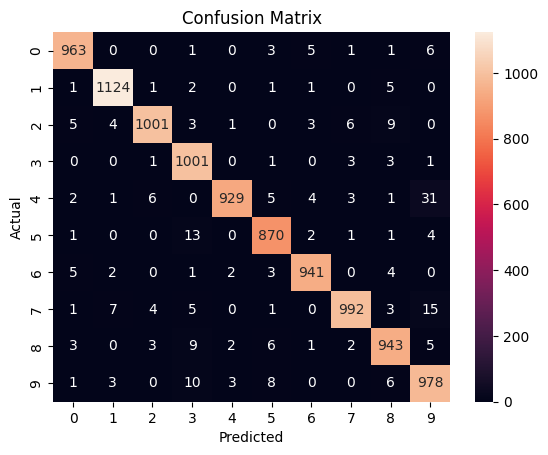

In [61]:
cm = confusion_matrix(y_true ,y_pred)
heatmap(cm, annot = True, fmt = 'd',
        xticklabels=list(range(10)),
        yticklabels = list(range(10)))
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

In [62]:
print("Acc: ", accuracy_score(y_true ,y_pred))
print("Classification report:\n ", classification_report(y_true ,y_pred))

Acc:  0.9742
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.99      0.95      0.97       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.94      0.97      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [63]:
example_input = torch.randn(features.shape).to(device)
traced_model = torch.jit.trace(estimator, example_input)

In [64]:
example_input = torch.randn(features.shape).to(device)
traced_model = torch.jit.trace(estimator, example_input)

In [65]:
# Save the scripted model
traced_model.save(PATH + "traced_model.pt")